In [1]:
from transformers import AutoFeatureExtractor, AutoModel
from collections import defaultdict
import pandas as pd
model_ckpt = "nateraw/vit-base-beans"
# model_ckpt = 'google/vit-base-patch16-384'
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

/home/grads/a/anath/anaconda3/envs/gcomb/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Dataset Preprocessing

In [2]:
from datasets import load_dataset
dataset = load_dataset("beans")
seed = 42
skewed_samples =[]
max_count = 10
cnt =0
for idx,label in enumerate(dataset["train"]['labels']):
    if label ==0:
        if cnt<max_count:
            skewed_samples.append(idx)
            cnt+=1

    else:
        skewed_samples.append(idx)
candidate_subset = dataset["train"].select(skewed_samples).shuffle(seed=seed)

In [3]:
import torch
import torchvision.transforms as T

# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp


# Here, we map embedding extraction utility on our subset of candidate images.
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)

Map:   0%|          | 0/699 [00:00<?, ? examples/s]

In [4]:
import numpy as np

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

In [5]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    scores += 1
    scores /=2
    return scores.numpy().tolist()


In [6]:
import matplotlib.pyplot as plt
from math import ceil

def show_images(images, cols=3, titles=None):
    """
    Display a list of PIL images in a grid.
    
    Args:
        images (list): A list of PIL Image objects to display.
        cols (int): Number of columns in the grid (default is 3).
        titles (list): Optional list of titles for each image (must match the number of images).
    """
    num_images = len(images)
    rows = ceil(num_images / cols)
    
    # Create subplots with dynamic number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    # Flatten the axes array for easy indexing, if needed
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Remove axis
            if titles and i < len(titles):
                ax.set_title(titles[i], fontsize=12)
        else:
            # Hide any unused subplot axes
            ax.axis('off')

    plt.tight_layout()
    plt.show()


In [7]:
# # @njit(fastmath=True,parallel=True)
# def facility_location(similarity,budget,ground_set):
#     # N = len(similarity)
#     N = similarity.shape[1]
#     candidate_set_size = similarity.shape[0]
#     max_obj = 0
#     total_cost = 0
#     solution_sparse = np.zeros(N)
#     max_similarity = np.zeros(candidate_set_size)

#     for _ in range(budget):
#         # max_element = -1
#         # obj_val = np.zeros(N)
#         gains = np.zeros(N)

#         for element in range(N):
#             if solution_sparse[element] == 0 and ground_set[element] == 1:

#                 for candidate in range(candidate_set_size):
#                     # obj_val[element] += max(max_similarity[candidate],similarity[candidate,element])
#                     gains[element] += similarity[candidate,element]


#         # if np.max(obj_val) == max_obj:
#         if np.max(gains) == 0:

#             break
#         else:
#             max_element = np.argmax(obj_val)
#             solution_sparse[max_element] = 1
#             # total_cost += costs[max_element]
#             for i in range(candidate_set_size):
#                 max_similarity[i] = max(max_similarity[i],similarity[i,max_element])
            
#         max_obj = obj_val[max_element]
#     return max_obj,solution_sparse

In [8]:
import numpy as np
from numba import njit


# @njit(fastmath=True, parallel=True)
def calculate_gains(candidate_similarity, query_similarity, solution_dense, size_solution, c=2):
    """
    Calculate the gains for each candidate based on the current solution.

    Args:
    candidate_similarity (np.ndarray): A 2D array representing candidate-candidate similarity matrix.
    query_similarity (np.ndarray): A 2D array representing candidate-query similarity matrix.
    solution_dense (np.ndarray): Indices of selected candidates in the solution.
    size_solution (int): Number of selected candidates in the solution.
    c (float): Constant multiplier for query similarity.

    Returns:
    np.ndarray: An array of gains for each candidate.
    """
    num_candidates = len(candidate_similarity)
    gains = np.zeros(num_candidates)

    for candidate in range(num_candidates):
        # print('candidate',candidate)
        # print(np.sum(query_similarity[:,candidate]) *2)
        # print(candidate_similarity[candidate, candidate])
        gain = 10 * np.sum(query_similarity[:,candidate]) - candidate_similarity[candidate, candidate]

        # print(gain)

        # Adjust gain based on current solution
        for selected_idx in range(size_solution):
            selected_candidate = solution_dense[selected_idx]
            gain -= 2 * candidate_similarity[candidate, selected_candidate]

        gains[candidate] = gain

    return gains

# @njit(fastmath=True, parallel=True)
def graph_cut(candidate_similarity, query_similarity, budget, ground_set):
    """
    Perform the graph cut optimization to maximize similarity between candidates and the query.

    Args:
    candidate_similarity (np.ndarray): A 2D array representing candidate-candidate similarity matrix.
    query_similarity (np.ndarray): A 2D array representing candidate-query similarity matrix.
    budget (int): The number of candidates to select.
    ground_set (list or np.ndarray): Set of candidate elements.

    Returns:
    obj_val (float): The final objective value achieved.
    solution_dense (np.ndarray): Indices of selected candidates.
    solution_sparse (np.ndarray): Sparse solution with binary representation (selected candidates are marked 1).
    """

    num_candidates = len(candidate_similarity)

    # Initialize variables
    solution_sparse = np.zeros(num_candidates)
    solution_dense = np.zeros(num_candidates, dtype=np.int32)
    size_solution = 0
    obj_val = 0.0
    c = 2  # Constant multiplier for query similarity

    # Loop over the budget to select candidates
    for _ in range(budget):
        # Calculate gains for all candidates
        gains = calculate_gains(candidate_similarity, query_similarity, solution_dense, size_solution, c)

        best_candidate = -1
        max_gain = -float('inf')  # Initialize max_gain to negative infinity to ensure the first gain is selected
        
        for i in range(num_candidates):
            if ground_set[i] == 1:  # Check if candidate is eligible (not already selected)
                if gains[i] > max_gain:  # Find the candidate with the maximum gain
                    max_gain = gains[i]
                    best_candidate = i

        if best_candidate == -1:
            # No valid candidate was found, stop the loop
            print("No valid candidate found, breaking the loop.")
            break

        # Select the candidate with the highest gain
        solution_dense[size_solution] = best_candidate
        solution_sparse[best_candidate] = 1
        size_solution += 1
        obj_val += gains[best_candidate]


    return obj_val, solution_dense[:size_solution], solution_sparse


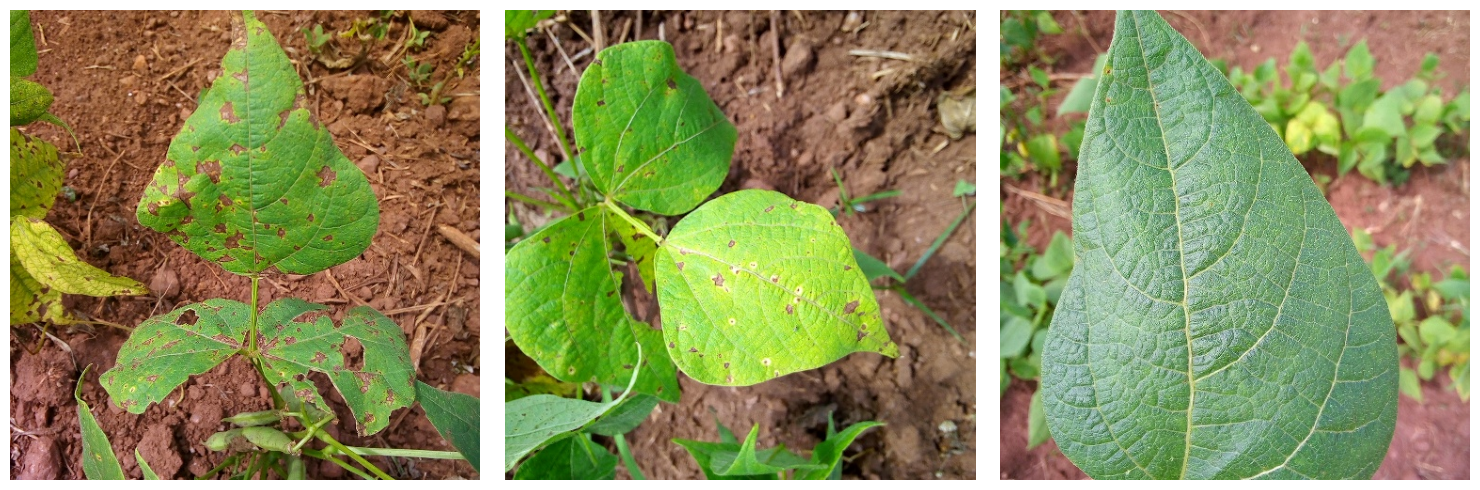

In [9]:
query_images=dataset["test"][[0,50,100]]["image"]
show_images(query_images) 
# Assuming `images` is a list or batch of images
query_images_transformed_batch = torch.stack([transformation_chain(query_image) for query_image in query_images])
query_images_transformed_batch = query_images_transformed_batch.to(device)
# Prepare the batch dictionary
new_batch = {"pixel_values": query_images_transformed_batch}
# Compute the embeddings for all images in the batch
with torch.no_grad():
    query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()


candidate_similarity = np.array([compute_scores(all_candidate_embeddings, all_candidate_embeddings[i]) for i in range(all_candidate_embeddings.shape[0])]) 
query_similarity = np.array([compute_scores(all_candidate_embeddings, query_embeddings[i]) for i in range(query_embeddings.shape[0])])

In [10]:
import numpy as np



def QS(candidate_similarity, query_similarity, delta=0.05, budget=5):
    N = len(candidate_similarity)
    print('Size of unpruned ground set', N)

    # Current objective value
    curr_obj = 0

    # Ground set, dense and sparse solutions
    ground_set = np.zeros(N)
    solution_dense = np.zeros(N, dtype=np.int32)
    solution_sparse = np.zeros(N)
    size_solution = 0

    for element in range(N):
        gains = calculate_gains(candidate_similarity, query_similarity, solution_dense, size_solution, solution_sparse)

        gain = gains[element]

        if gain >= delta / budget * curr_obj:
            curr_obj += gain
            # Mark the element as selected in the ground set
            ground_set[element] = 1
            solution_sparse[element] = 1
            solution_dense[size_solution] = element
            size_solution += 1

    print('Size of pruned ground set(QS)', ground_set.sum())
    return ground_set



In [15]:
import random
from tqdm import tqdm
import heapq

def calculate_obj(candidate_similarity,query_similarity,solution):

    obj_val = 0
    # print(solution)
    for candidate in solution:
        obj_val += 10 * np.sum(query_similarity[:,candidate])


    solution = list(solution)

    for  i in range(len(solution)):
        for j in range(i+1,len(solution)):
            obj_val -= candidate_similarity[i,j]

    return obj_val

def SS(candidate_similarity,query_similarity,r=8,c=8):

    n = len(candidate_similarity)
    pruned_universe=set()

    universe = list(range(n))

    while len(universe)> r*np.log2(n):
        U=random.sample(universe,int(r*np.log2(n)))
        
        universe = set(universe)

        for element in tqdm(U):
            universe.remove(element)

        U = set(U)
        pruned_universe=pruned_universe.union(U)
        universe_gain=calculate_obj(candidate_similarity,query_similarity,universe) # f(V)

        universe_u_gain = {} # f(V U u)
        u_gain = {} # f(u)
        # get all neighbors 
        
        
        for u in tqdm(U):
            universe.add(u)
            universe_u_gain[u] = calculate_obj (candidate_similarity,query_similarity ,universe)
            universe.remove(u)
            u_gain[u] = calculate_obj (candidate_similarity,query_similarity, [u])


        lst = []

        for v in tqdm(universe):

            w=float('inf')
            
            # for u in graph.neighbors(v):
                
            for u in U:
                # universe_copy=universe.copy()
                # universe_copy.append(u)
                
                local_gain = calculate_obj(candidate_similarity,query_similarity,[u,v])-u_gain[u] # f(v U u) -f(u)
                # print(local_gain)

                global_gain = universe_u_gain[u]-universe_gain
                w=min(w,local_gain-global_gain)

            lst.append((w,v))

        remove_nodes=heapq.nsmallest(int((1-1/np.sqrt(c))*len(universe)), lst)
        # print(remove_nodes)
        universe = set(universe)
        for w,node in tqdm(remove_nodes):
            # if w>0:
            #     print(w)
            universe.remove(node)
            # universe.re
        universe = list(universe)
        

        

    pruned_universe=pruned_universe.union(set(universe))

    ground_set = np.zeros(n)
    for element in pruned_universe:
        ground_set[element] = 1

    print('Size of pruned ground set(SS)', ground_set.sum())

    return ground_set





In [17]:
df = defaultdict(list)
delta = 0.05

ground_set_SS = SS(candidate_similarity,query_similarity)
for budget in [5,10,15,20]:

    N = len(candidate_similarity)

    ground_set_QS = QS(candidate_similarity,query_similarity,delta,budget)
    retrived_images = np.where(ground_set_QS==1)[0]

    obj_val_FS_QS=graph_cut(candidate_similarity=candidate_similarity,
                            query_similarity=query_similarity,
                            budget=budget,ground_set=ground_set_QS)[0]
    
    
    obj_val_FS_SS=graph_cut(candidate_similarity=candidate_similarity,
                            query_similarity=query_similarity,
                            budget=budget,ground_set=ground_set_SS)[0]

    

    obj_val_FS=graph_cut(candidate_similarity=candidate_similarity,
                            query_similarity=query_similarity,
                            budget=budget,ground_set=np.ones(N))[0]
    
    num_repeat = 5
    obj_val_FS_Random = 0
    for i in range(num_repeat):
        # Randomly select a mask
        random_mask = np.random.choice(np.arange(N), size=int(ground_set_QS.sum()), replace=False)
        
        # Create the random ground set
        random_ground_set = np.zeros(N)
        random_ground_set[random_mask] = 1 
        
        # Calculate the objective value using graph_cut
        obj_val_FS_Random += graph_cut(candidate_similarity=candidate_similarity,
                                    query_similarity=query_similarity,
                                    budget=budget,
                                    ground_set=random_ground_set)[0]
        
    
    obj_val_FS_Random /= num_repeat

    # random_mask= np.random.choice(np.arange(N), size=int(ground_set.sum()), replace=False)
    # random_ground_set = np.zeros(N)
    # random_ground_set[random_mask] = 1 
    # obj_val_FS_Random=graph_cut(candidate_similarity=candidate_similarity,
    #                             query_similarity=query_similarity,
    #                             budget=budget,ground_set=random_ground_set)[0]

    # obj_val_FS_QS=facility_location(similarity,budget=budget,ground_set=ground_set)[0]
    # obj_val_FS=facility_location(similarity,budget=budget,ground_set=np.ones(N))[0]

    # random_mask= np.random.choice(np.arange(N), size=int(ground_set.sum()), replace=False)
    # random_ground_set = np.zeros(N)
    # random_ground_set[random_mask] = 1 
    # obj_val_FS_Random=facility_location(similarity,budget=budget,ground_set=random_ground_set)[0]

    df['Budget'].append(budget)
    df['Obj(FS+QS)'].append(obj_val_FS_QS)
    df['Obj(FS+SS)'].append(obj_val_FS_SS)
    df['Obj(FS)'].append(obj_val_FS)
    df['Obj(FS+Random)'].append(obj_val_FS_Random)

    # show_images(candidate_subset[retrived_images]["image"])
    # break

df = pd.DataFrame(df)
print(df)

100%|██████████| 94/94 [00:00<00:00, 2042821.64it/s]


Size of pruned ground set(SS) 202.0
Size of unpruned ground set 699
Size of pruned ground set(QS) 19.0
Size of unpruned ground set 699
Size of pruned ground set(QS) 20.0
Size of unpruned ground set 699
Size of pruned ground set(QS) 20.0
Size of unpruned ground set 699
Size of pruned ground set(QS) 20.0
   Budget  Obj(FS+QS)  Obj(FS+SS)     Obj(FS)  Obj(FS+Random)
0       5   73.528170   74.711790   74.711790       63.079531
1      10  114.115621  115.658539  115.707249       92.590150
2      15  127.627180  129.122685  129.178070       87.877757
3      20  114.250338  115.577315  115.751440       62.503646


In [18]:
# Calculating the ratios for each row
df['Ratio_Obj(FS+QS)_Obj(FS)'] = df['Obj(FS+QS)'] / df['Obj(FS)']
df['Ratio_Obj(FS+SS)_Obj(FS)'] = df['Obj(FS+SS)'] / df['Obj(FS)']
df['Ratio_Obj(FS+Random)_Obj(FS)'] = df['Obj(FS+Random)'] / df['Obj(FS)']

In [19]:
df

,Budget,Obj(FS+QS),Obj(FS+SS),Obj(FS),Obj(FS+Random),Ratio_Obj(FS+QS)_Obj(FS),Ratio_Obj(FS+SS)_Obj(FS),Ratio_Obj(FS+Random)_Obj(FS)
0,5,73.528170,74.711790,74.711790,63.079531,0.984158,1.000000,0.844305
1,10,114.115621,115.658539,115.707249,92.590150,0.986244,0.999579,0.800210
2,15,127.627180,129.122685,129.178070,87.877757,0.987994,0.999571,0.680284
3,20,114.250338,115.577315,115.751440,62.503646,0.987032,0.998496,0.539982


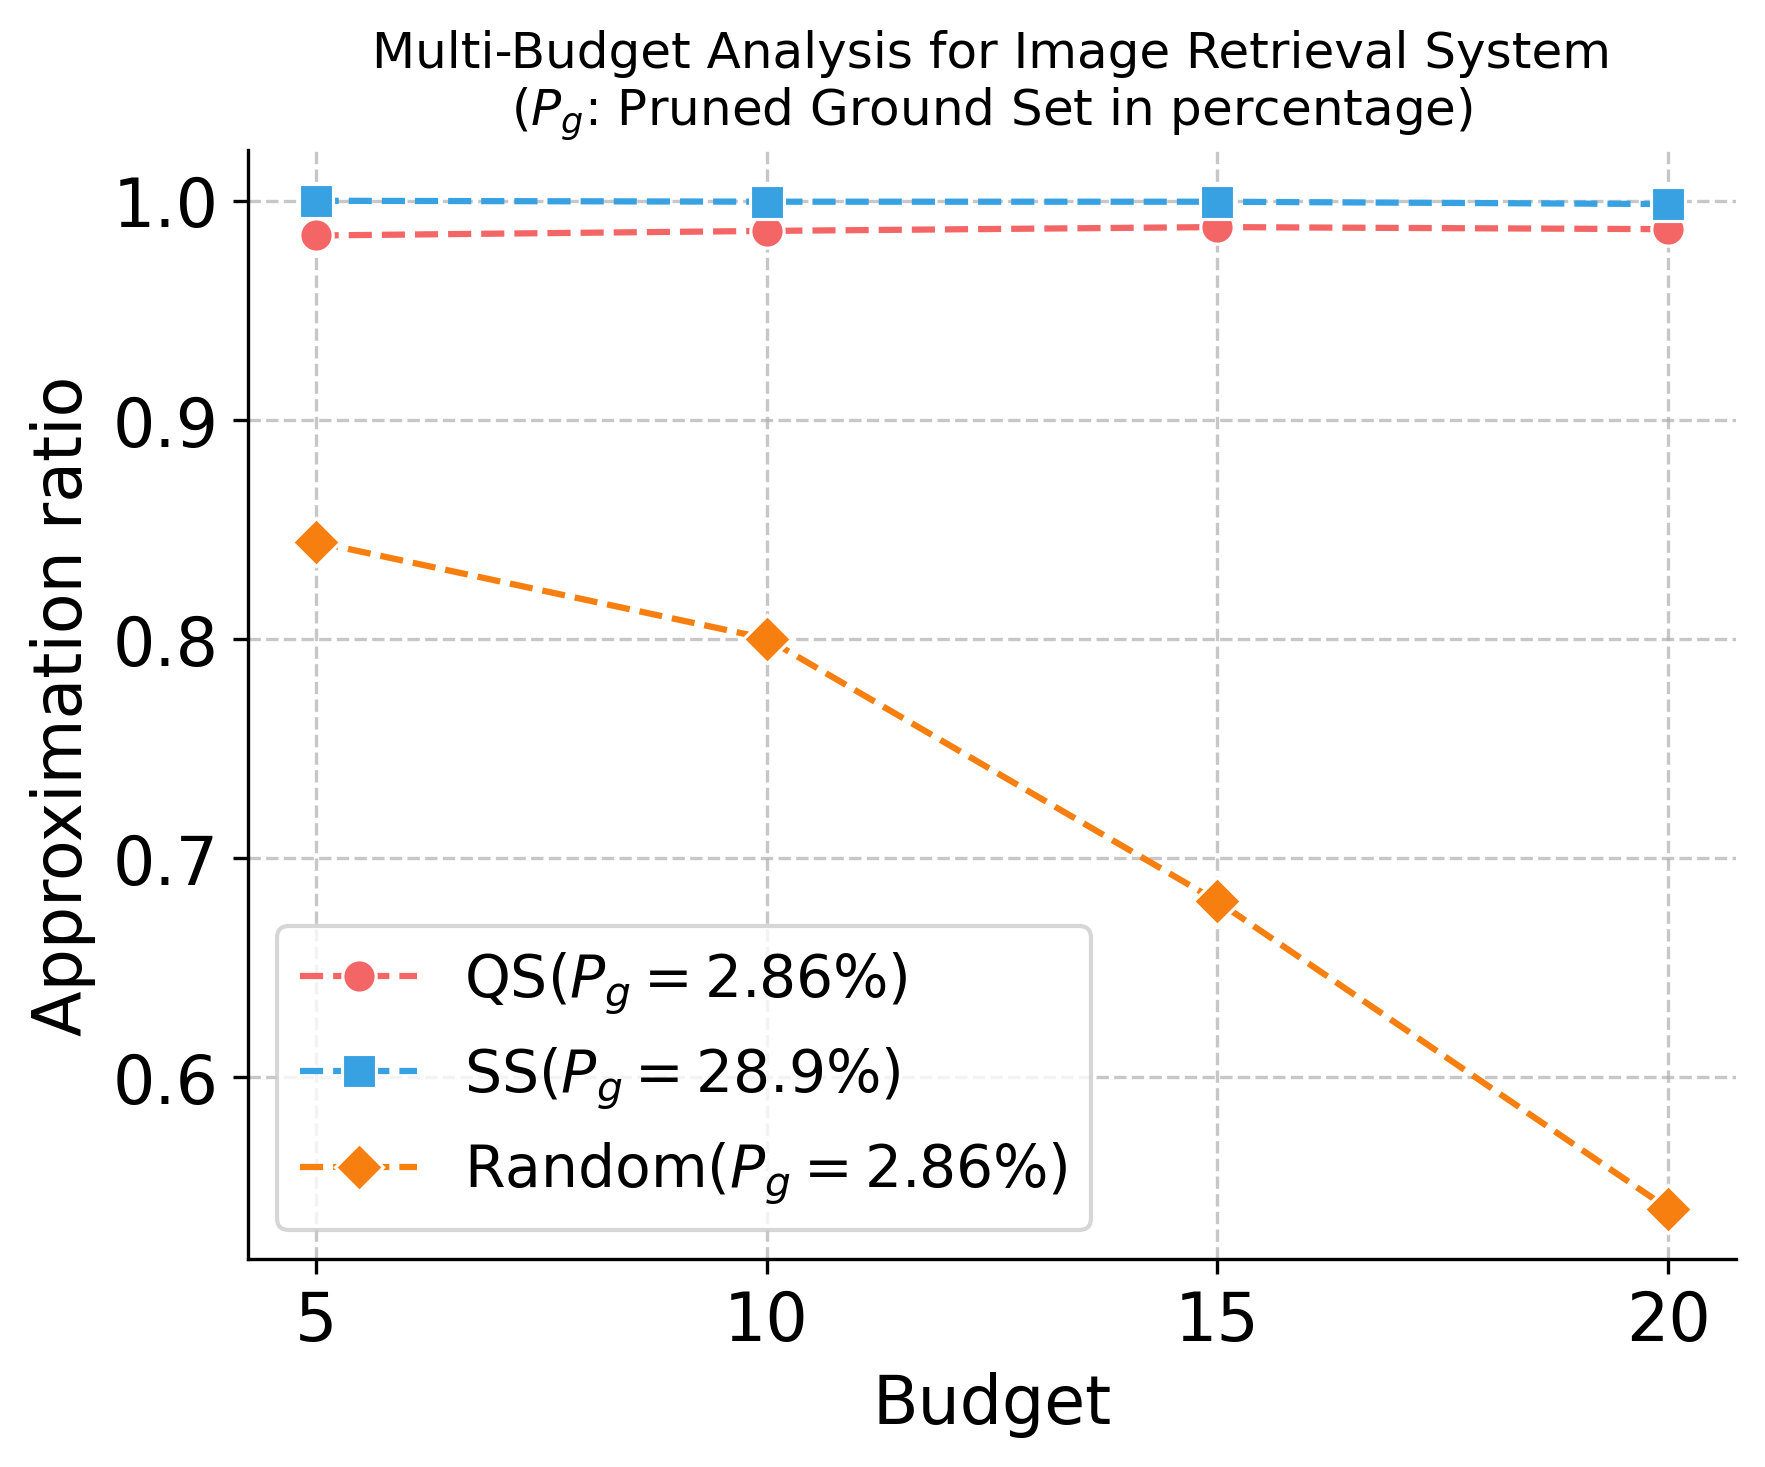

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(dpi=300)

# Plotting the ratios with larger markers and improved styling
sns.lineplot(data=df, x='Budget', y='Ratio_Obj(FS+QS)_Obj(FS)', label='QS$(P_g=2.86\%)$', linestyle='--', marker='o', 
             markersize=8, color='#f46666')
sns.lineplot(data=df, x='Budget', y='Ratio_Obj(FS+SS)_Obj(FS)', label='SS$(P_g=28.9\%)$',linestyle='--' ,marker='s', 
             markersize=8, color='#37a1e2')
sns.lineplot(data=df, x='Budget', y='Ratio_Obj(FS+Random)_Obj(FS)', label='Random$(P_g=2.86\%)$',linestyle='--', marker='D', 
             markersize=8, color='#f67f10')

# Labeling the plot
# plt.title('Ratios of Different Objectives Relative to Obj(FS)')
# plt.xlabel('Budget')
# plt.ylabel('Ratio')
# plt.legend(title='Objective', title_fontsize='13', fontsize='11')

fontsize = 16

# plt.title('Multi Budget results for Image retrival system \n $P_g =$ percentage of the ground set')
plt.title('Multi-Budget Analysis for Image Retrieval System\n($P_g$: Pruned Ground Set in percentage)')

plt.xlabel('Budget',fontsize=fontsize)
plt.ylabel('Approximation ratio',fontsize=fontsize)

plt.xticks(fontsize=fontsize )
plt.yticks(fontsize=fontsize )

# Adding a light grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.locator_params(nbins=6)
# Legend
plt.legend(fontsize='14')
sns.despine()

# Show the plot
plt.show()
